# Mixture of Experts (MoE) Layer in PyTorch

This notebook demonstrates the Mixture of Experts architecture, a key technique for scaling neural networks.

We'll cover:
1. Expert networks - Individual specialized networks
2. Gating mechanism - Router that selects experts
3. MoE layer implementation from scratch
4. Top-K routing strategy
5. Practical example with visualization

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Expert Network

Each expert is a simple feed-forward network that specializes in processing certain types of inputs.

In [2]:
class Expert(nn.Module):
    """
    A single expert network - a simple feed-forward network.
    
    Args:
        input_dim: Input feature dimension
        hidden_dim: Hidden layer dimension
        output_dim: Output feature dimension
        dropout: Dropout probability
    """
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        """
        Forward pass through the expert network.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_dim)
        
        Returns:
            Output tensor of shape (batch_size, seq_len, output_dim)
        """
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Test the expert network
batch_size, seq_len, input_dim = 2, 4, 8
hidden_dim, output_dim = 16, 8

expert = Expert(input_dim, hidden_dim, output_dim)
x = torch.randn(batch_size, seq_len, input_dim)
output = expert(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Expert parameters: {sum(p.numel() for p in expert.parameters())}")

Input shape: torch.Size([2, 4, 8])
Output shape: torch.Size([2, 4, 8])
Expert parameters: 280


## 3. Gating Network

The gating network (router) decides which experts should process each input token.
It outputs a probability distribution over experts for each token.

In [ ]:
class GatingNetwork(nn.Module):
    """
    Gating network that routes inputs to experts.
    
    Args:
        input_dim: Input feature dimension
        num_experts: Number of expert networks
    """
    def __init__(self, input_dim, num_experts):
        super().__init__()
        self.gate = nn.Linear(input_dim, num_experts)
        self.num_experts = num_experts
    
    def forward(self, x):
        """
        Compute gating weights for each expert.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_dim)
        
        Returns:
            Gate logits of shape (batch_size, seq_len, num_experts)
        """
        # Compute logits for each expert
        gate_logits = self.gate(x)  # (batch_size, seq_len, num_experts)
        return gate_logits

# Test the gating network
num_experts = 4
gate = GatingNetwork(input_dim, num_experts)
gate_logits = gate(x)

# Apply softmax to get probabilities
gate_probs = F.softmax(gate_logits, dim=-1)

print(f"Gate logits shape: {gate_logits.shape}")
print(f"Gate probabilities shape: {gate_probs.shape}")
print(f"\nExample gate probabilities for first token:")
print(gate_probs[0, 0])  # Probabilities for each expert
print(f"Sum of probabilities: {gate_probs[0, 0].sum().item():.4f}")

Gate logits shape: torch.Size([2, 4, 4])
Gate probabilities shape: torch.Size([2, 4, 4])

Example gate probabilities for first token:
tensor([0.3241, 0.3285, 0.1762, 0.1712], grad_fn=<SelectBackward0>)
Sum of probabilities: 1.0000


## 4. Mixture of Experts Layer with Top-K Routing

The MoE layer combines multiple expert networks with a gating mechanism.
We use Top-K routing where each token is processed by the top-k experts (typically k=2).

In [ ]:
class MixtureOfExperts(nn.Module):
    """
    Mixture of Experts layer with Top-K routing.
    
    Args:
        input_dim: Input feature dimension
        hidden_dim: Hidden dimension for experts
        output_dim: Output feature dimension
        num_experts: Number of expert networks
        top_k: Number of experts to use per token (typically 2)
        dropout: Dropout probability
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_experts=8, top_k=2, dropout=0.1):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.output_dim = output_dim
        
        # Create multiple expert networks
        self.experts = nn.ModuleList([
            Expert(input_dim, hidden_dim, output_dim, dropout)
            for _ in range(num_experts)
        ])
        
        # Gating network
        self.gate = GatingNetwork(input_dim, num_experts)
    
    def forward(self, x):
        """
        Forward pass through the MoE layer.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_dim)
        
        Returns:
            output: Output tensor of shape (batch_size, seq_len, output_dim)
            aux_loss: Auxiliary load balancing loss
            expert_indices: Indices of selected experts for visualization
        """
        batch_size, seq_len, input_dim = x.shape
        
        # Get gate logits
        gate_logits = self.gate(x)  # (batch_size, seq_len, num_experts)
        
        # Apply softmax to get probabilities
        gate_probs = F.softmax(gate_logits, dim=-1)
        
        # Select top-k experts
        top_k_probs, top_k_indices = torch.topk(gate_probs, self.top_k, dim=-1)
        # Normalize top-k probabilities
        top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)
        
        # Initialize output
        output = torch.zeros(batch_size, seq_len, self.output_dim, device=x.device)
        
        # Process each expert
        for i, expert in enumerate(self.experts):
            # Find which tokens use this expert
            expert_mask = (top_k_indices == i).any(dim=-1)  # (batch_size, seq_len)
            
            if expert_mask.any():
                # Get expert output for all inputs (for simplicity)
                expert_output = expert(x)  # (batch_size, seq_len, output_dim)
                
                # Get the weight for this expert for each token
                expert_weights = torch.where(
                    top_k_indices == i,
                    top_k_probs,
                    torch.zeros_like(top_k_probs)
                ).sum(dim=-1, keepdim=True)  # (batch_size, seq_len, 1)
                
                # Add weighted expert output
                output += expert_weights * expert_output
        
        # Compute load balancing auxiliary loss
        # Encourage uniform distribution of tokens across experts
        expert_usage = torch.zeros(self.num_experts, device=x.device)
        for i in range(self.num_experts):
            expert_usage[i] = (top_k_indices == i).float().mean()
        
        # Auxiliary loss encourages balanced expert usage
        aux_loss = self.num_experts * (expert_usage ** 2).sum()
        
        return output, aux_loss, top_k_indices

# Test the MoE layer
moe = MixtureOfExperts(
    input_dim=8,
    hidden_dim=32,
    output_dim=8,
    num_experts=4,
    top_k=2
)

x = torch.randn(2, 6, 8)
output, aux_loss, expert_indices = moe(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Auxiliary loss: {aux_loss.item():.4f}")
print(f"Expert indices shape: {expert_indices.shape}")
print(f"\nSelected experts for first sequence:")
print(expert_indices[0])

Input shape: torch.Size([2, 6, 8])
Output shape: torch.Size([2, 6, 8])
Auxiliary loss: 1.3056
Expert indices shape: torch.Size([2, 6, 2])

Selected experts for first sequence:
tensor([[2, 1],
        [2, 0],
        [1, 3],
        [1, 2],
        [2, 1],
        [2, 3]])


## 5. Visualize Expert Selection

Let's visualize which experts are selected for different tokens.

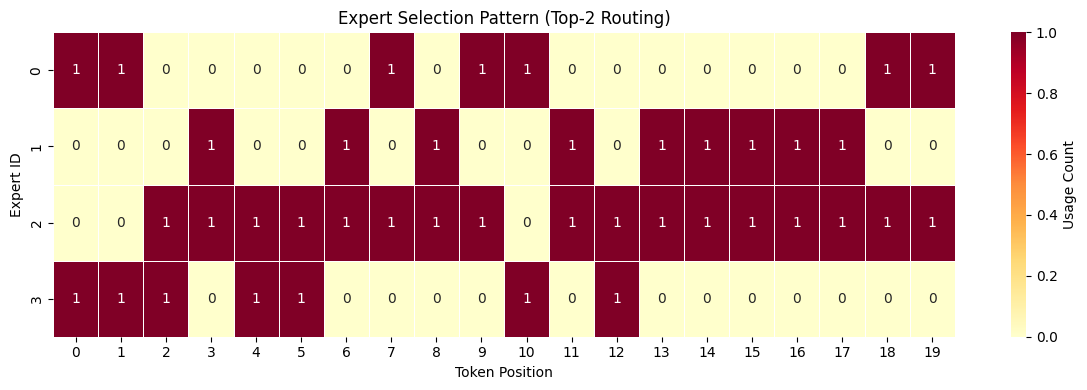


Expert usage statistics:
Expert 0: 7 times (17.5%)
Expert 1: 9 times (22.5%)
Expert 2: 17 times (42.5%)
Expert 3: 7 times (17.5%)

Auxiliary loss (lower is more balanced): 1.1700


In [5]:
# Generate a longer sequence for better visualization
x = torch.randn(1, 20, 8)  # Single batch, 20 tokens
output, aux_loss, expert_indices = moe(x)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 4))

# Create a matrix showing which experts are used for each token
expert_matrix = torch.zeros(20, 4)  # seq_len x num_experts
for token_idx in range(20):
    for k in range(2):  # top_k = 2
        expert_idx = expert_indices[0, token_idx, k].item()
        expert_matrix[token_idx, expert_idx] += 1

# Plot heatmap
sns.heatmap(expert_matrix.T, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Usage Count'},
            ax=ax, linewidths=0.5)
ax.set_xlabel('Token Position')
ax.set_ylabel('Expert ID')
ax.set_title('Expert Selection Pattern (Top-2 Routing)')
plt.tight_layout()
plt.show()

# Print expert usage statistics
expert_counts = expert_matrix.sum(dim=0)
print("\nExpert usage statistics:")
for i, count in enumerate(expert_counts):
    print(f"Expert {i}: {count.item():.0f} times ({count.item()/40*100:.1f}%)")
print(f"\nAuxiliary loss (lower is more balanced): {aux_loss.item():.4f}")

## 6. Training Example with MoE

Let's create a simple classification task to demonstrate how MoE can be trained.

In [ ]:
class MoEClassifier(nn.Module):
    """
    Simple classifier using Mixture of Experts.
    """
    def __init__(self, input_dim, hidden_dim, num_classes, num_experts=4, top_k=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.moe = MixtureOfExperts(
            input_dim=hidden_dim,
            hidden_dim=hidden_dim * 2,
            output_dim=hidden_dim,
            num_experts=num_experts,
            top_k=top_k
        )
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.aux_loss_weight = 0.01  # Weight for auxiliary loss
    
    def forward(self, x):
        # x: (batch_size, input_dim)
        x = self.embedding(x).unsqueeze(1)  # (batch_size, 1, hidden_dim)
        x, aux_loss, _ = self.moe(x)
        x = x.squeeze(1)  # (batch_size, hidden_dim)
        logits = self.classifier(x)  # (batch_size, num_classes)
        return logits, aux_loss

# Create synthetic dataset
torch.manual_seed(42)
num_samples = 1000
input_dim = 20
num_classes = 3

# Generate random data
X = torch.randn(num_samples, input_dim)
y = torch.randint(0, num_classes, (num_samples,))

# Create model
model = MoEClassifier(
    input_dim=input_dim,
    hidden_dim=64,
    num_classes=num_classes,
    num_experts=4,
    top_k=2
).to(device)

# Move data to device
X = X.to(device)
y = y.to(device)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 50
batch_size = 32
losses = []
aux_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_aux_loss = 0.0
    
    # Mini-batch training
    for i in range(0, num_samples, batch_size):
        batch_X = X[i:i+batch_size]
        batch_y = y[i:i+batch_size]
        
        optimizer.zero_grad()
        
        # Forward pass
        logits, aux_loss = model(batch_X)
        
        # Compute loss
        classification_loss = criterion(logits, batch_y)
        total_loss = classification_loss + model.aux_loss_weight * aux_loss
        
        # Backward pass
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += classification_loss.item()
        epoch_aux_loss += aux_loss.item()
    
    epoch_loss /= (num_samples // batch_size)
    epoch_aux_loss /= (num_samples // batch_size)
    losses.append(epoch_loss)
    aux_losses.append(epoch_aux_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Aux Loss: {epoch_aux_loss:.4f}")

print("\nTraining completed!")

Epoch [10/50], Loss: 0.6281, Aux Loss: 1.0728
Epoch [20/50], Loss: 0.1837, Aux Loss: 1.0762
Epoch [30/50], Loss: 0.0741, Aux Loss: 1.0762
Epoch [40/50], Loss: 0.0624, Aux Loss: 1.0747
Epoch [50/50], Loss: 0.0382, Aux Loss: 1.0760

Training completed!


## 7. Visualize Training Progress

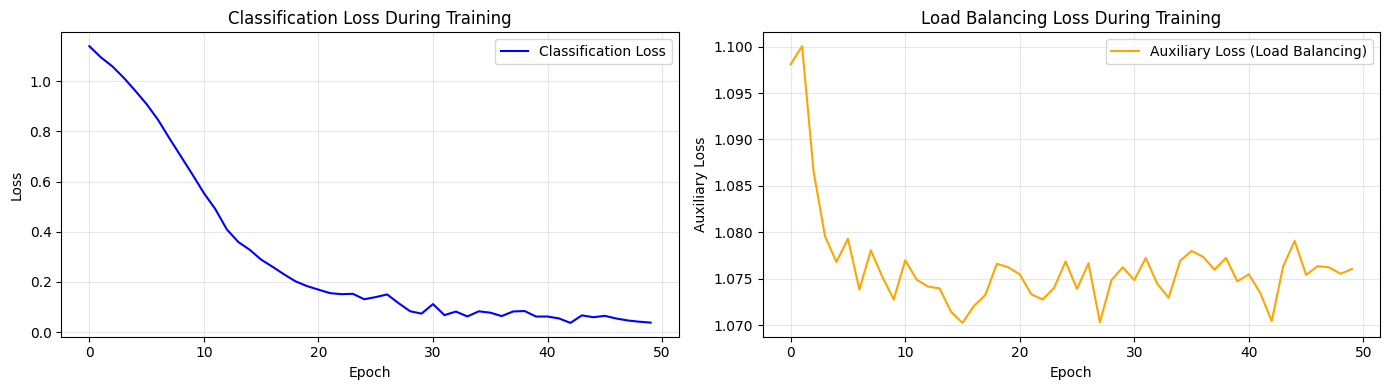


Final accuracy: 99.70%


In [7]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Classification loss
ax1.plot(losses, label='Classification Loss', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Classification Loss During Training')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Auxiliary loss
ax2.plot(aux_losses, label='Auxiliary Loss (Load Balancing)', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Auxiliary Loss')
ax2.set_title('Load Balancing Loss During Training')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate model
model.eval()
with torch.no_grad():
    logits, _ = model(X)
    predictions = torch.argmax(logits, dim=1)
    accuracy = (predictions == y).float().mean()
    print(f"\nFinal accuracy: {accuracy.item()*100:.2f}%")

## 8. Compare MoE with Standard Feed-Forward Network

Standard model training completed!


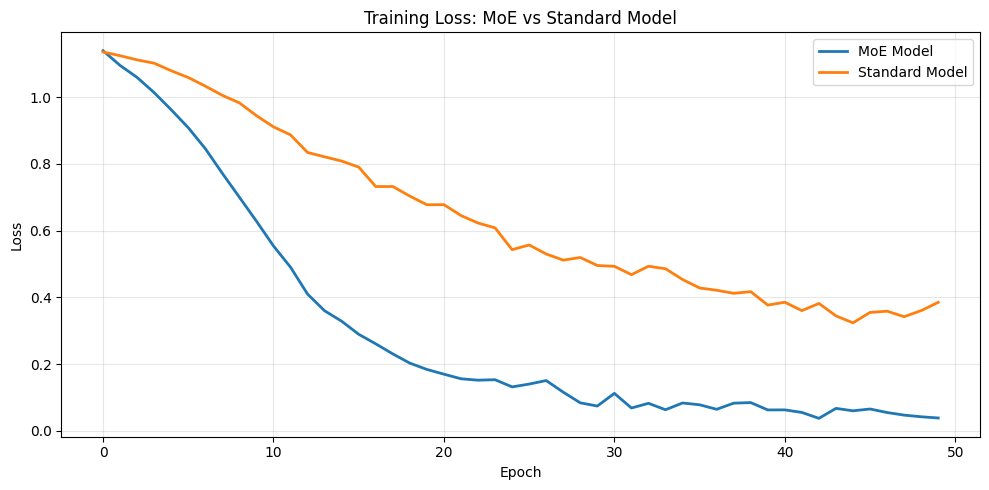


Final Results:
MoE Model Accuracy: 99.70%
Standard Model Accuracy: 98.40%

Parameter Counts:
MoE Model: 68,103 parameters
Standard Model: 18,115 parameters
MoE has 3.76x more parameters


In [8]:
class StandardClassifier(nn.Module):
    """Standard classifier without MoE for comparison."""
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(StandardClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Create standard model
standard_model = StandardClassifier(
    input_dim=input_dim,
    hidden_dim=64,
    num_classes=num_classes
).to(device)

# Train standard model
optimizer_std = torch.optim.Adam(standard_model.parameters(), lr=0.001)
standard_losses = []

standard_model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    
    for i in range(0, num_samples, batch_size):
        batch_X = X[i:i+batch_size]
        batch_y = y[i:i+batch_size]
        
        optimizer_std.zero_grad()
        logits = standard_model(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer_std.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= (num_samples // batch_size)
    standard_losses.append(epoch_loss)

print("Standard model training completed!")

# Compare models
plt.figure(figsize=(10, 5))
plt.plot(losses, label='MoE Model', linewidth=2)
plt.plot(standard_losses, label='Standard Model', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss: MoE vs Standard Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Evaluate both models
standard_model.eval()
with torch.no_grad():
    moe_logits, _ = model(X)
    moe_predictions = torch.argmax(moe_logits, dim=1)
    moe_accuracy = (moe_predictions == y).float().mean()
    
    std_logits = standard_model(X)
    std_predictions = torch.argmax(std_logits, dim=1)
    std_accuracy = (std_predictions == y).float().mean()

print(f"\nFinal Results:")
print(f"MoE Model Accuracy: {moe_accuracy.item()*100:.2f}%")
print(f"Standard Model Accuracy: {std_accuracy.item()*100:.2f}%")

# Compare parameter counts
moe_params = sum(p.numel() for p in model.parameters())
std_params = sum(p.numel() for p in standard_model.parameters())
print(f"\nParameter Counts:")
print(f"MoE Model: {moe_params:,} parameters")
print(f"Standard Model: {std_params:,} parameters")
print(f"MoE has {(moe_params/std_params):.2f}x more parameters")

## Summary

In this notebook, we covered:

1. **Expert Networks**: Simple feed-forward networks that specialize in processing certain inputs
2. **Gating Network**: Router that decides which experts should process each token
3. **Top-K Routing**: Strategy where each token is processed by the top-k experts (typically k=2)
4. **Load Balancing**: Auxiliary loss that encourages uniform expert usage
5. **Training**: How to train an MoE model with both classification and auxiliary losses

### Key Advantages of MoE:
- **Scalability**: Can scale to very large models by adding more experts
- **Efficiency**: Only a subset of experts is active for each input (sparse activation)
- **Specialization**: Different experts can specialize in different patterns
- **Conditional Computation**: Computation is adaptive based on input

### Practical Considerations:
- Load balancing is crucial to prevent expert collapse (all tokens going to one expert)
- Top-K routing (typically k=2) balances capacity and efficiency
- The auxiliary loss weight needs tuning based on the task
- MoE works best with large-scale models and datasets